In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClusteri
from sklearn.datasets import make_blobs

from fastcluster import ward
from fastcluster import linkage
from mlpy import MFastHCluster 
from nilearn import plotting as niplt
from neurosynth.base.dataset import Dataset
import sys
from sklearn import decomposition as sk_decomp
from os.path import exists, join
from os import makedirs
from neurosynth.analysis.cluster import Clusterable
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from nibabel import nifti1
from mlpy import MFastHCluster
import pickle
from neurosynth.base import imageutils

import pandas as pd

### Time scikit learn  ward

In [16]:
%%timeit
X, y = make_blobs(2000, 100, 10)
c = AgglomerativeClustering(1000)
c.fit(X)

1 loops, best of 3: 4.08 s per loop


In [17]:
%%timeit
X, y = make_blobs(3000, 100, 10)
c = AgglomerativeClustering(1000)
c.fit(X)

1 loops, best of 3: 13.5 s per loop


In [12]:
%%timeit
X, y = make_blobs(4000, 100, 10)
c = AgglomerativeClustering(1000)
c.fit(X)

1 loops, best of 3: 31.2 s per loop


In [33]:
?AgglomerativeClustering

### Time fastcluster

In [6]:
# %%timeit
X, y = make_blobs(1000, 100, 10)
cf = MFastHCluster(method='ward')
cf.linkage(X)

In [56]:
%%timeit
X, y = make_blobs(2000, 100, 10)
cf = MFastHCluster(method='ward')
cf.linkage(X)

1 loops, best of 3: 674 ms per loop


In [57]:
%%timeit
X, y = make_blobs(3000, 100, 10)
cf = MFastHCluster(method='ward')
cf.linkage(X)

1 loops, best of 3: 1.54 s per loop


In [58]:
%%timeit
X, y = make_blobs(10000, 100, 10)
cf = MFastHCluster(method='ward')
cf.linkage(X)

1 loops, best of 3: 18.9 s per loop


### Wrap MFastHCluster in fit predict API and cluster whole brain

In [4]:
class FastWard(object):
    def __init__(self):
        pass
    
    def fit(self, X):
        from mlpy import MFastHCluster 
        self.cf = MFastHCluster(method='ward')
        self.cf.linkage(X)
        
    def predict(self, n):
        for i in range(1, self.cf.cut(0).shape[0]):
            labels = self.cf.cut(i)
            if np.bincount(labels).shape[0] == n:
                break
                
        return labels

In [2]:
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("../data/datasets/abs_60topics_filt_jul.pkl")

In [65]:
# ## Set up same PCA pipeline for both Kmeans and hierarchical clustering

# from sklearn import decomposition as sk_decomp
# from os.path import exists, join
# from neurosynth.analysis.cluster import Clusterable
# import nibabel as nib
# from sklearn.metrics import pairwise_distances
# from nibabel import nifti1
# from mlpy import MFastHCluster

# roi_mask = '../masks/FPN_hierarchical_mv120.nii.gz'
# ns =  range(2, 40, 4)
# save_images = False
# output_dir = None
# out_model = None

# roi = Clusterable(dataset, roi_mask, min_studies=120)

# reference = Clusterable(dataset, min_studies=120)
# reduce_reference = sk_decomp.RandomizedPCA(100)
# reference = reference.transform(reduce_reference, transpose=True)

distances = pairwise_distances(roi.data, reference.data,
                               metric='correlation')

In [123]:
## 
ns = [60, 78, 100]

In [124]:
## Kmeans
output_dir = '../results/clustering/test_hierarchical/'

for n_clusters in ns:
    
    clustering_algorithm = KMeans(n_clusters=n_clusters)
    labels = clustering_algorithm.fit_predict(distances) + 1
    
    header = roi.masker.get_header()
    header['cal_max'] = labels.max()
    header['cal_min'] = labels.min()
    voxel_labels = roi.masker.unmask(labels)
    img = nifti1.Nifti1Image(voxel_labels, None, header)

    if output_dir is not None:
        sub_dir = join(output_dir, 'kmeans')

        if not exists(sub_dir):
            makedirs(sub_dir)

        filename = 'cluster_labels_k%d.nii.gz' % n_clusters
        outfile = join(sub_dir, filename)

        img.to_filename(outfile)

In [71]:
## Fast Ward
fw_algorithm = FastWard()
fw_algorithm.fit(distances)

In [72]:
pickle.dump(fw_algorithm, open('../results/clustering/fw_trained_FPN_min120.pkl', 'w'))

In [5]:
fw_algorithm = pickle.load(open('../results/clustering/fw_trained_FPN_min120.pkl', 'r'))

In [2]:
from scipy.cluster.hierarchy import dendrogram

In [4]:
?dendrogram

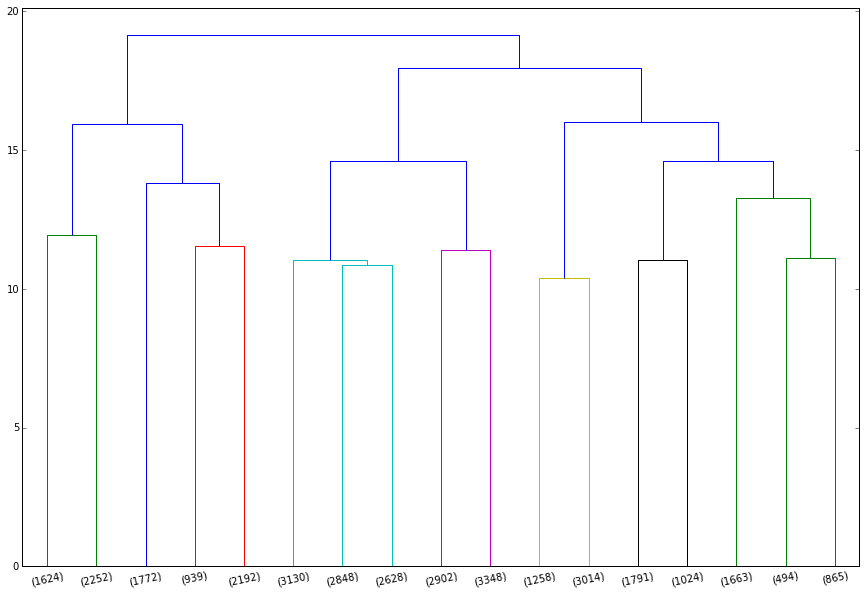

In [81]:
plt.figure(figsize=(15,10))
dendrogram(fw_algorithm.cf.Z(), 17,  truncate_mode='lastp')
plt.savefig('../results/clustering/test_hierarchical/dendogram_FPN_120v_17.png')

In [10]:
## Output (instead of by k i'm going by "cuts")
output_dir = '../results/clustering/hierarchical/'
for i in range(5, 10):
    labels = fw_algorithm.cf.cut(i) + 1
    n_clusters = np.bincount(fw_algorithm.cf.cut(i)).shape[0]

    print n_clusters
#     # Make nibabel image
#     header = roi.masker.get_header()
#     header['cal_max'] = labels.max()
#     header['cal_min'] = labels.min()
#     voxel_labels = np.round(roi.masker.unmask(labels))
#     img = nifti1.Nifti1Image(voxel_labels, None, header)

#     if output_dir is not None:
#         sub_dir = join(output_dir, 'fastward_FPN_min120')
#         if not exists(sub_dir):
#             makedirs(sub_dir)
            
#         filename = 'cluster_labels_k%d.nii.gz' % n_clusters
#         outfile = join(sub_dir, filename)
#         img.to_filename(outfile)


77
53
37
27
22


In [12]:
fw_algorithm.cf.cut

<bound method MFastHCluster.cut of <mlpy.fastcluster.fasthc.MFastHCluster instance at 0x10b8ffb48>>

In [66]:
from sklearn.metrics import silhouette_score
## Silhouette score
silhouettes = []
for i in range(3, 25):
    labels = fw_algorithm.cf.cut(i) + 1
    n_clusters = np.bincount(fw_algorithm.cf.cut(i)).shape[0]
        
    if n_clusters < 2:
        break
    
    sil = silhouette_score(distances, labels, sample_size = 2000)
    silhouettes.append([n_clusters, sil])

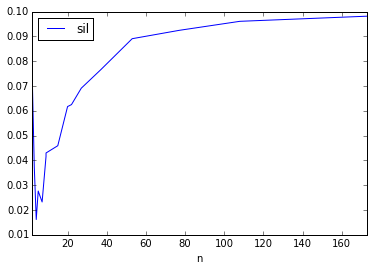

In [67]:
silhouettes = pd.DataFrame(silhouettes, columns=['n', 'sil'])
silhouettes = silhouettes.sort('n')
silhouettes.plot('n', 'sil')

### Permutation test

In [23]:
def permutation_silhouette(boot_n):
    ## Fast Ward
    fw_algorithm_ran = FastWard()

    reference_data_ran = np.apply_along_axis(np.random.permutation, 0, reference.data)
    roi_data_ran = np.apply_along_axis(np.random.permutation, 0, roi.data)
    distances = pairwise_distances(roi_data_ran, reference_data_ran, metric='correlation')

    fw_algorithm_ran.fit(distances)

    ## Silhouette score
    silhouettes_perm = []
    for i in range(3, 25):
        labels = fw_algorithm_ran.cf.cut(i) + 1
        n_clusters = np.bincount(fw_algorithm_ran.cf.cut(i)).shape[0]

        if n_clusters < 2:
            break

        sil = silhouette_score(distances, labels, sample_size = 2000)
        silhouettes_perm.append([boot_n, n_clusters, sil])

### Cluster LFC to compare silhouette scores

In [70]:
lfc_roi = Clusterable(dataset, '../masks/LFC/LFC.nii.gz', min_studies=120)
lfc_distances = pairwise_distances(roi.data, reference.data,
                               metric='correlation')

In [75]:
## Fast Ward
fw_algorithm_lfc= FastWard()
fw_algorithm_lfc.fit(lfc_distances)

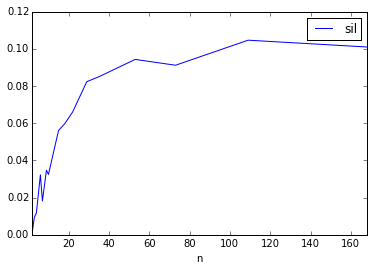

In [76]:
## Silhouette score
sLFC = []
for i in range(3, 25):
    labels = fw_algorithm_lfc.cf.cut(i) + 1
    n_clusters = np.bincount(fw_algorithm_lfc.cf.cut(i)).shape[0]
        
    if n_clusters < 2:
        break
    
    sil = silhouette_score(distances, labels, sample_size = 2000)
    sLFC.append([n_clusters, sil])

sLFC = pd.DataFrame(sLFC, columns=['n', 'sil'])
sLFC = sLFC.sort('n')
sLFC.plot('n', 'sil')

### Visualize clustering results

#### Fast ward

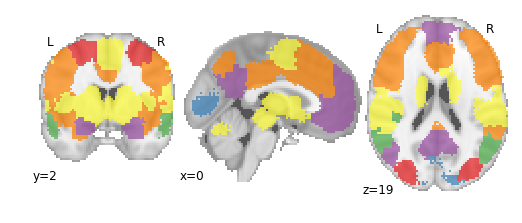

In [106]:
import glob
import matplotlib.colors as mplcolors
import seaborn as sns
for f in glob.glob('../results/clustering/hierarchical/fastward_min120/*k6.*'):
    nf = nib.load(f)
    labels = np.round(nf.get_data())
    header = nf.get_header()
    header['cal_max'] = labels.max()
    header['cal_min'] = labels.min()
    img = nifti1.Nifti1Image(labels, nf.get_affine(), header)
    niplt.plot_roi(img, draw_cross=False, cmap = mplcolors.ListedColormap(sns.color_palette('Set1', 6)))

In [ ]:
niplt.plot

In [97]:
nf.ge

array([ 0.        ,  1.00004578,  2.        ,  3.00004578,  4.        ,
        5.00004578,  6.        ])

In [89]:
f

'../results/clustering/hierarchical/fastward_min120/cluster_labels_k6.nii.gz'

#### Kmeans

../results/clustering/test_hierarchical/kmeans/cluster_labels_k100.nii.gz
../results/clustering/test_hierarchical/kmeans/cluster_labels_k60.nii.gz
../results/clustering/test_hierarchical/kmeans/cluster_labels_k78.nii.gz
../results/clustering/test_hierarchical/kmeans/cluster_labels_k80.nii.gz


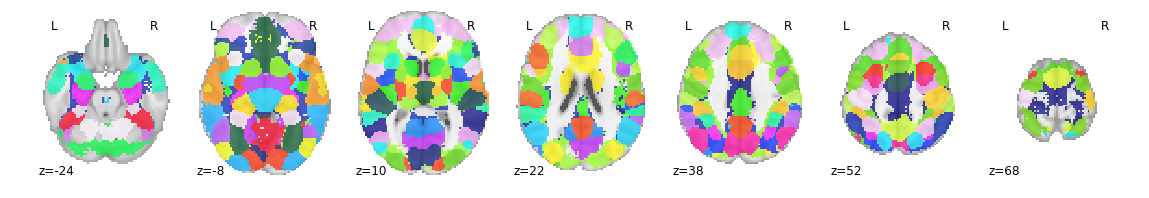

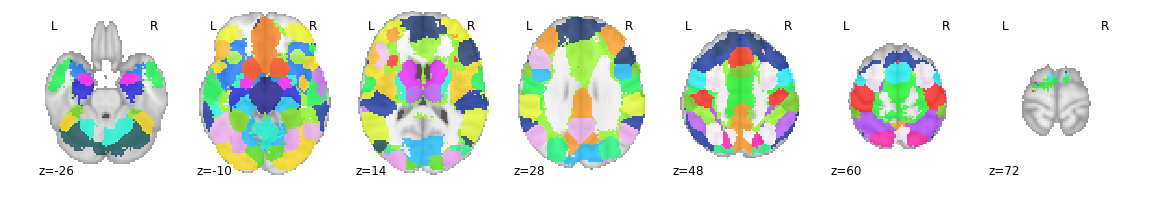

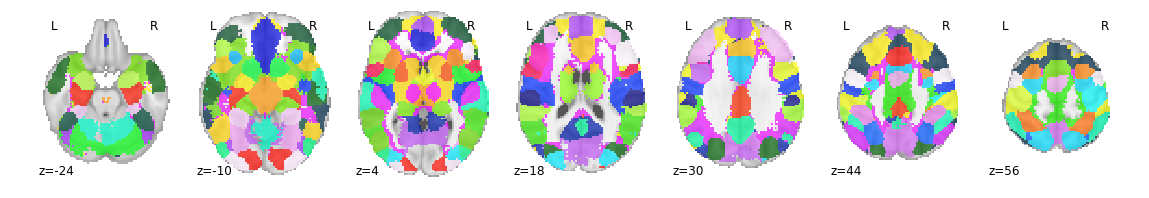

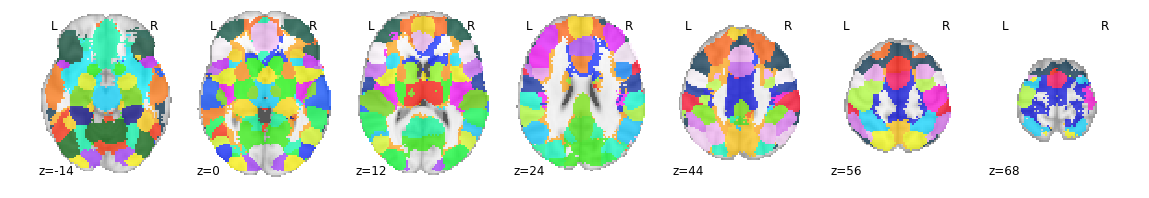

In [129]:
for f in glob.glob('../results/clustering/test_hierarchical/kmeans/*'):
    print f
    niplt.plot_roi(f, display_mode='z')

In [67]:
## Get only FPC
sev = np.round(imageutils.load_imgs('../results/clustering/test_hierarchical/fastward_min120/cluster_labels_k6.nii.gz', dataset.masker))

In [68]:
sev[sev != 5.0] = 0
sev[sev == 5.0] = 1

In [69]:
imageutils.save_img(sev, '../masks/FPN_hierarchical_mv120.nii.gz', dataset.masker)